<a href="https://colab.research.google.com/github/PercyMayaba/Accident-Probability-Prediction-using-Telematics-Data/blob/main/AccidentProbabilityPredictionusingTelematics_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install required packages
!pip install tslearn scikit-learn imbalanced-learn tensorflow seaborn plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tslearn.generators import random_walk_blobs
import warnings
warnings.filterwarnings('ignore')

print("All packages installed and imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 4.7 MB/s eta 0:00:00
All packages installed and imported successfully!


In [ ]:
# Cell 2: Generate synthetic telematics data
def generate_synthetic_telematics_data(n_samples=10000, sequence_length=50):
    """
    Generate synthetic telematics data with time-series sequences
    """
    np.random.seed(42)

    # Generate base features
    data = {
        'driver_id': np.arange(n_samples),
        'age': np.random.randint(18, 70, n_samples),
        'driving_experience': np.random.randint(1, 50, n_samples),
        'annual_mileage': np.random.normal(12000, 4000, n_samples),
        'time_of_day': np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], n_samples),
        'road_type': np.random.choice(['Highway', 'Urban', 'Rural'], n_samples)
    }

    # Generate time-series sequences for each driver
    telematics_sequences = []
    accident_probabilities = []

    for i in range(n_samples):
        # Base risk factors
        age_risk = max(0, (data['age'][i] - 25) / 50) if data['age'][i] > 25 else 0
        experience_risk = max(0, 1 - (data['driving_experience'][i] / 20))
        mileage_risk = min(1, data['annual_mileage'][i] / 20000)

        # Generate time-series features
        sequence = np.zeros((sequence_length, 5))  # 5 features per time step

        for t in range(sequence_length):
            # Harsh braking (0-1 scale)
            harsh_braking = np.random.beta(2, 8) + np.random.normal(0, 0.1)

            # Sharp turns (0-1 scale)
            sharp_turns = np.random.beta(3, 10) + np.random.normal(0, 0.1)

            # Weather conditions (0-1, higher = worse)
            weather = np.random.beta(4, 6) if np.random.random() < 0.3 else np.random.beta(2, 8)

            # Driver fatigue index (0-1)
            fatigue = np.random.beta(3, 7) + (t / sequence_length) * 0.2

            # Speed variation
            speed_var = np.random.normal(0.5, 0.2)

            sequence[t] = [harsh_braking, sharp_turns, weather, fatigue, speed_var]

        telematics_sequences.append(sequence)

        # Calculate accident probability based on features
        base_risk = (age_risk * 0.1 + experience_risk * 0.2 + mileage_risk * 0.1 +
                    np.mean(sequence[:, 0]) * 0.3 +  # harsh braking
                    np.mean(sequence[:, 1]) * 0.2 +  # sharp turns
                    np.mean(sequence[:, 3]) * 0.1)   # fatigue

        accident_prob = 1 / (1 + np.exp(-10 * (base_risk - 0.5)))
        accident_probabilities.append(accident_prob)

    # Convert to binary labels (accident vs no accident)
    accident_labels = (np.array(accident_probabilities) > np.percentile(accident_probabilities, 85)).astype(int)

    # Create DataFrame
    df = pd.DataFrame(data)
    df['accident_probability'] = accident_probabilities
    df['accident_occurred'] = accident_labels

    telematics_array = np.array(telematics_sequences)

    return df, telematics_array

# Generate data
print("Generating synthetic telematics data...")
df, telematics_data = generate_synthetic_telematics_data(10000, 50)
print(f"Data shape: {df.shape}")
print(f"Telematics sequences shape: {telematics_data.shape}")
print(f"Accident rate: {df['accident_occurred'].mean():.3f}")

Generating synthetic telematics data...
Data shape: (10000, 8)
Telematics sequences shape: (10000, 50, 5)
Accident rate: 0.150


=== Dataset Overview ===
   driver_id  age  driving_experience  annual_mileage time_of_day road_type  \
0          0   56                  11    13047.442637       Night     Urban   
1          1   69                  22    16936.679435     Morning     Urban   
2          2   46                  24     7943.354939       Night     Urban   
3          3   32                   1     9212.095929     Evening   Highway   
4          4   60                  18    16381.396778   Afternoon     Rural   

   accident_probability  accident_occurred  
0              0.182820                  0  
1              0.145514                  0  
2              0.056097                  0  
3              0.282912                  1  
4              0.127313                  0  

=== Basic Statistics ===
         driver_id           age  driving_experience  annual_mileage  \
count  10000.00000  10000.000000         10000.00000    10000.000000   
mean    4999.50000     43.539400            24.83940    1204

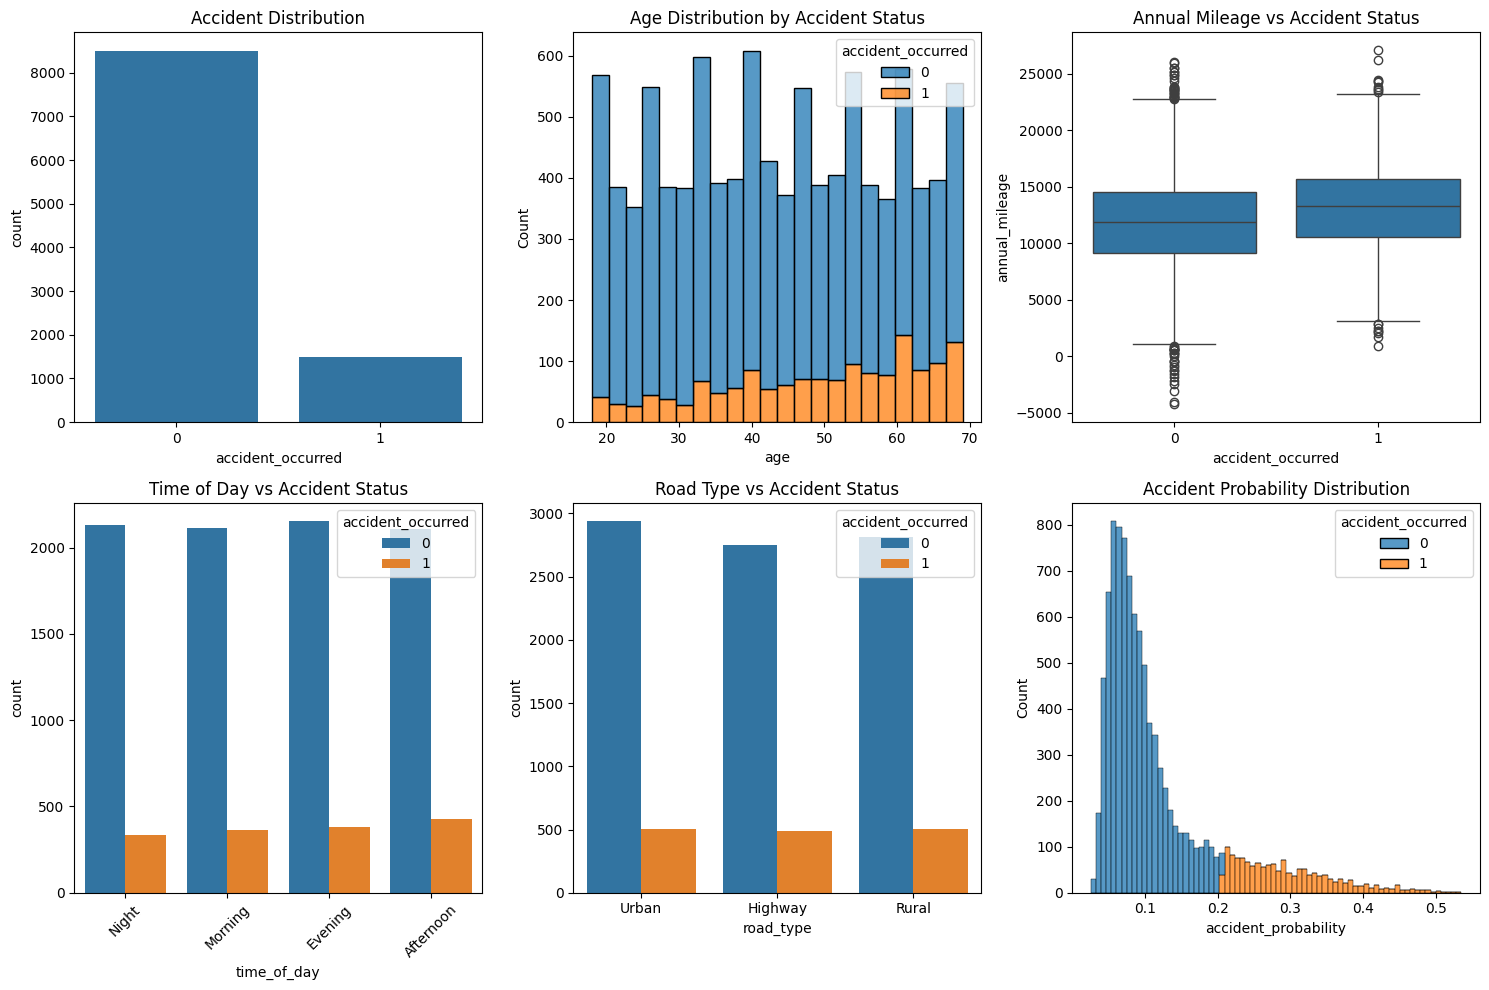

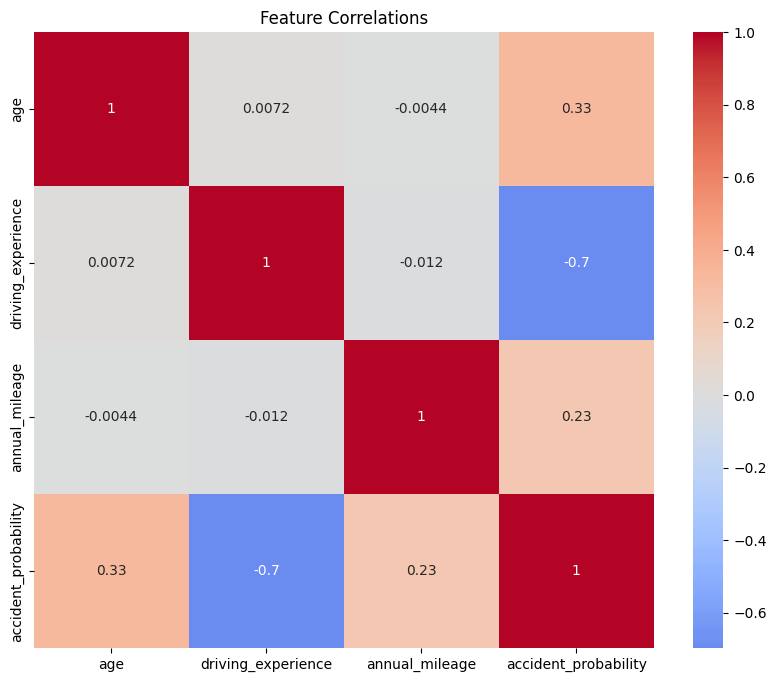

In [ ]:
# Cell 3: Exploratory Data Analysis
print("=== Dataset Overview ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

# Plot accident distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(data=df, x='accident_occurred')
plt.title('Accident Distribution')

plt.subplot(2, 3, 2)
sns.histplot(data=df, x='age', hue='accident_occurred', multiple="stack")
plt.title('Age Distribution by Accident Status')

plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='accident_occurred', y='annual_mileage')
plt.title('Annual Mileage vs Accident Status')

plt.subplot(2, 3, 4)
sns.countplot(data=df, x='time_of_day', hue='accident_occurred')
plt.title('Time of Day vs Accident Status')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
sns.countplot(data=df, x='road_type', hue='accident_occurred')
plt.title('Road Type vs Accident Status')

plt.subplot(2, 3, 6)
sns.histplot(data=df, x='accident_probability', hue='accident_occurred', multiple="stack")
plt.title('Accident Probability Distribution')

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
numeric_cols = ['age', 'driving_experience', 'annual_mileage', 'accident_probability']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

In [ ]:
# Cell 4: Feature Engineering and Preprocessing
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
print("Preprocessing data...")

label_encoders = {}
categorical_cols = ['time_of_day', 'road_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features for traditional ML
feature_columns = ['age', 'driving_experience', 'annual_mileage',
                   'time_of_day_encoded', 'road_type_encoded']

# Create aggregated features from telematics data
df['avg_harsh_braking'] = telematics_data[:, :, 0].mean(axis=1)
df['avg_sharp_turns'] = telematics_data[:, :, 1].mean(axis=1)
df['avg_weather_risk'] = telematics_data[:, :, 2].mean(axis=1)
df['avg_fatigue'] = telematics_data[:, :, 3].mean(axis=1)
df['speed_variability'] = telematics_data[:, :, 4].std(axis=1)

feature_columns.extend(['avg_harsh_braking', 'avg_sharp_turns', 'avg_weather_risk',
                       'avg_fatigue', 'speed_variability'])

X = df[feature_columns]
y = df['accident_occurred']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")

Preprocessing data...
Feature matrix shape: (10000, 10)
Target distribution: accident_occurred
0    8500
1    1500
Name: count, dtype: int64


In [ ]:
# Cell 5: Handle Class Imbalance and Split Data
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training accident rate: {y_train.mean():.3f}")
print(f"Test accident rate: {y_test.mean():.3f}")

# Handle class imbalance using SMOTE
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Training set: {X_train_resampled.shape}")
print(f"After SMOTE - Training accident rate: {y_train_resampled.mean():.3f}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Training set: (8000, 10)
Test set: (2000, 10)
Training accident rate: 0.150
Test accident rate: 0.150

Applying SMOTE to handle class imbalance...
After SMOTE - Training set: (13600, 10)
After SMOTE - Training accident rate: 0.500


=== Logistic Regression Model ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1700
           1       0.92      0.99      0.96       300

    accuracy                           0.99      2000
   macro avg       0.96      0.99      0.97      2000
weighted avg       0.99      0.99      0.99      2000

ROC-AUC Score: 0.9994

Feature Importance (Logistic Regression):
               feature  importance
1   driving_experience  -19.083893
0                  age    3.305297
2       annual_mileage    2.478390
5    avg_harsh_braking    0.838545
6      avg_sharp_turns    0.482793
3  time_of_day_encoded   -0.236159
8          avg_fatigue    0.224391
4    road_type_encoded   -0.200864
7     avg_weather_risk    0.047918
9    speed_variability    0.025979


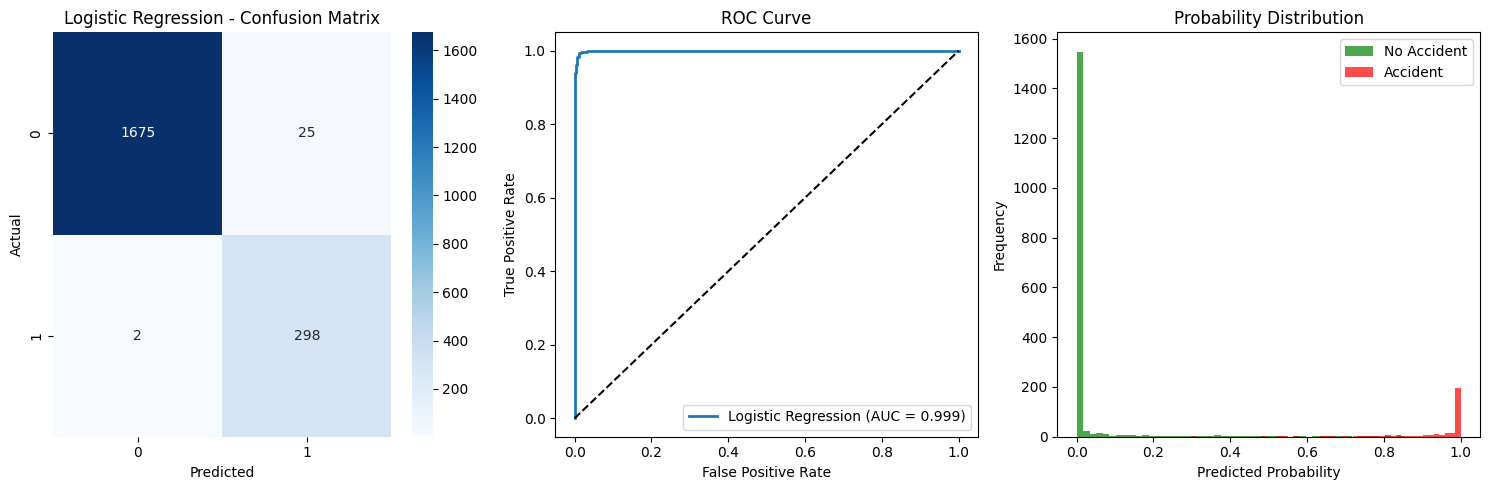

In [ ]:
# Cell 6: Logistic Regression Model
print("=== Logistic Regression Model ===")

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train_resampled)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': lr_model.coef_[0]
}).sort_values('importance', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression):")
print(feature_importance)

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Probability distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_lr[y_test == 0], bins=50, alpha=0.7, label='No Accident', color='green')
plt.hist(y_pred_proba_lr[y_test == 1], bins=50, alpha=0.7, label='Accident', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Random Forest Model
print("=== Random Forest Model ===")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance_rf)

=== Random Forest Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1700
           1       0.87      0.96      0.91       300

    accuracy                           0.97      2000
   macro avg       0.93      0.97      0.95      2000
weighted avg       0.97      0.97      0.97      2000

ROC-AUC Score: 0.9961

Feature Importance (Random Forest):
               feature  importance
1   driving_experience    0.814124
0                  age    0.053301
2       annual_mileage    0.037108
4    road_type_encoded    0.029194
3  time_of_day_encoded    0.023316
5    avg_harsh_braking    0.011752
9    speed_variability    0.008325
6      avg_sharp_turns    0.008078
7     avg_weather_risk    0.007813
8          avg_fatigue    0.006987


In [ ]:
# Cell 8: Prepare Data for LSTM Model
print("=== Preparing Data for LSTM Model ===")

# Split telematics data according to the same train-test split
train_indices, test_indices = train_test_split(
    range(len(telematics_data)), test_size=0.2, random_state=42, stratify=y
)

X_seq_train = telematics_data[train_indices]
X_seq_test = telematics_data[test_indices]

# Also include static features for LSTM
static_features_train = X_train[['age', 'driving_experience', 'annual_mileage']].values
static_features_test = X_test[['age', 'driving_experience', 'annual_mileage']].values

print(f"Sequence training data: {X_seq_train.shape}")
print(f"Sequence test data: {X_seq_test.shape}")
print(f"Static features training: {static_features_train.shape}")
print(f"Static features test: {static_features_test.shape}")

# Scale the sequence data
sequence_scaler = StandardScaler()
X_seq_train_scaled = sequence_scaler.fit_transform(
    X_seq_train.reshape(-1, X_seq_train.shape[-1])
).reshape(X_seq_train.shape)

X_seq_test_scaled = sequence_scaler.transform(
    X_seq_test.reshape(-1, X_seq_test.shape[-1])
).reshape(X_seq_test.shape)

print("Sequence data scaled successfully!")

=== Preparing Data for LSTM Model ===
Sequence training data: (8000, 50, 5)
Sequence test data: (2000, 50, 5)
Static features training: (8000, 3)
Static features test: (2000, 3)
Sequence data scaled successfully!


In [ ]:
# Cell 9: Build and Train LSTM Model
print("=== Building LSTM Model ===")

def create_lstm_model(sequence_length, n_features, n_static_features):
    """Create LSTM model with static features"""

    # Sequence input
    sequence_input = tf.keras.layers.Input(shape=(sequence_length, n_features), name='sequence_input')

    # LSTM layers
    lstm_layer1 = LSTM(64, return_sequences=True, dropout=0.2)(sequence_input)
    lstm_layer2 = LSTM(32, dropout=0.2)(lstm_layer1)

    # Static features input
    static_input = tf.keras.layers.Input(shape=(n_static_features,), name='static_input')

    # Combine LSTM output with static features
    combined = tf.keras.layers.concatenate([lstm_layer2, static_input])

    # Dense layers
    dense1 = Dense(32, activation='relu')(combined)
    dropout1 = Dropout(0.3)(dense1)
    batch_norm1 = BatchNormalization()(dropout1)

    dense2 = Dense(16, activation='relu')(batch_norm1)
    dropout2 = Dropout(0.2)(dense2)

    # Output layer
    output = Dense(1, activation='sigmoid')(dropout2)

    model = tf.keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return model

# Create model
lstm_model = create_lstm_model(
    sequence_length=50,
    n_features=5,
    n_static_features=3
)

print("LSTM Model Summary:")
lstm_model.summary()

# Train the model
print("\n=== Training LSTM Model ===")
history = lstm_model.fit(
    [X_seq_train_scaled, static_features_train],
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(
        [X_seq_test_scaled, static_features_test],
        y_test
    ),
    verbose=1,
    class_weight={0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
)

=== Building LSTM Model ===
LSTM Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 64)    │     17,920 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,152 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,097 (125.38 KB)

 Non-trainable params: 64 (256.00 B)


=== Training LSTM Model ===
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - AUC: 0.5535 - accuracy: 0.6295 - loss: 1.2035 - val_AUC: 0.9189 - val_accuracy: 0.5875 - val_loss: 0.6344
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - AUC: 0.7187 - accuracy: 0.6202 - loss: 1.0172 - val_AUC: 0.8458 - val_accuracy: 0.5005 - val_loss: 0.6768
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - AUC: 0.7843 - accuracy: 0.6428 - loss: 0.8933 - val_AUC: 0.9762 - val_accuracy: 0.7785 - val_loss: 0.3891
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - AUC: 0.7958 - accuracy: 0.6693 - loss: 0.8021 - val_AUC: 0.9790 - val_accuracy: 0.8040 - val_loss: 0.3327
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - AUC: 0.8047 - accuracy: 0.6592 - loss: 0.7922 - val_AUC: 0.9890 - val_accuracy: 0.8795 - val_loss: 0.1934
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - AUC: 0.7904 - accuracy: 0.6547 - loss: 0.7979 - val_AUC: 0.8590 - val_accuracy: 0.6200 - val_loss: 0.5374

=== LSTM Model Evaluation ===
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1700
           1       0.61      1.00      0.76       300

    accuracy                           0.90      2000
   macro avg       0.81      0.94      0.85      2000
weighted avg       0.94      0.90      0.91      2000

ROC-AUC Score: 0.9777


KeyError: 'auc'

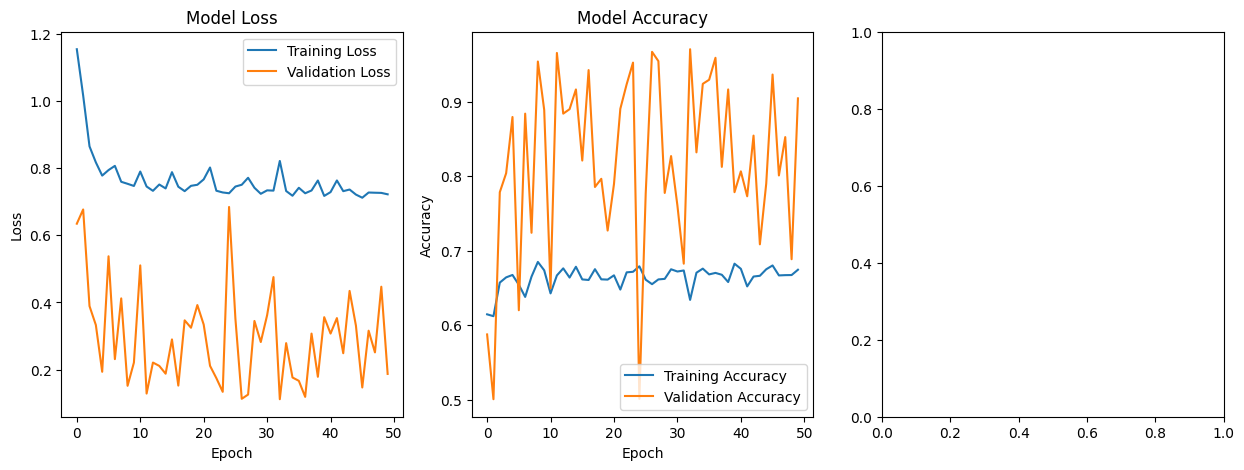

In [ ]:
# Cell 10: Evaluate LSTM Model
print("=== LSTM Model Evaluation ===")

# Predictions
y_pred_proba_lstm = lstm_model.predict([X_seq_test_scaled, static_features_test]).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_lstm))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lstm):.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Compare all models
plt.figure(figsize=(10, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})')

# LSTM ROC
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_proba_lstm)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_score(y_test, y_pred_proba_lstm):.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()